In [1]:
from math import ceil
import os
from pathlib import Path
import numpy as np
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
cwd = os.getcwd()
origin_path = Path(cwd).parent.__str__()
dataset_path = os.path.sep.join((origin_path, "asset", "data", "dataset"))
models_path = os.path.sep.join((origin_path, "asset", "data", "models"))
images_path = os.path.sep.join((dataset_path, "images"))
train_path = os.path.sep.join((dataset_path, "train"))
test_path = os.path.sep.join((dataset_path, "test"))
val_path = os.path.sep.join((dataset_path, "val"))

In [3]:
def show_result(steps: dict, gen_test, _model):
    """
    Used to display model's results after his training
    :param steps: contains all the history of the training model
    """
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_title("Learning curves")
    ax.set(xlabel='Epochs', ylabel='Metrics')
    sns.lineplot(x=range(len(steps["loss"])), y=steps["loss"], label="train loss", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["val_loss"], label="val loss", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["accuracy"], label="train accuracy", ax=ax)
    sns.lineplot(x=range(len(steps["loss"])), y=steps["val_accuracy"], label="val accuracy", ax=ax)

    gen_test.reset()
    y_true = gen_test.classes
    y_pred = np.argmax(_model.predict(x=gen_test, steps=test_step_per_epoch), axis=1)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)
    return cf_matrix

## I - Create generators

In [4]:
image_shape = (224, 224, 3)
epochs = 50
callback = lambda x: [EarlyStopping(monitor='val_accuracy', mode="max", patience=2), ModelCheckpoint(filepath=os.path.sep.join((models_path, f"{x}.h5")), monitor='val_accuracy', save_best_only=True)]
batch_size = 32
optimizer = Adam(learning_rate=.000_1)

In [5]:
# generators
train_gen = ImageDataGenerator(rescale=1/255.0)
test_gen = ImageDataGenerator(rescale=1/255.0)
train_gen_augmented = ImageDataGenerator(rescale=1/255.0, rotation_range=30, horizontal_flip=True, vertical_flip=True,	width_shift_range=0.1, height_shift_range=0.1,zoom_range=.1, shear_range=0.1, fill_mode="nearest")

X_train = train_gen.flow_from_directory(train_path, target_size=(224,224), classes=["0", "1"], batch_size=batch_size, shuffle=True)
X_val = train_gen.flow_from_directory(val_path, target_size=(224,224), classes=["0", "1"], batch_size=batch_size, shuffle=True)

X_train_augmented = train_gen_augmented.flow_from_directory(train_path, target_size=(224,224), classes=["0", "1"], batch_size=batch_size, shuffle=True)
X_val_augmented = train_gen_augmented.flow_from_directory(val_path, target_size=(224,224), classes=["0", "1"], batch_size=batch_size, shuffle=True)

X_test = test_gen.flow_from_directory(test_path, target_size=(224,224), classes=["0", "1"], batch_size=batch_size, shuffle=True)

Found 3663 images belonging to 2 classes.
Found 610 images belonging to 2 classes.
Found 3663 images belonging to 2 classes.
Found 610 images belonging to 2 classes.
Found 1833 images belonging to 2 classes.


In [6]:
train_step_per_epoch = int(ceil(len(X_train.classes)*.85/ batch_size))
validation_step_per_epoch = int( ceil(len(X_train.classes)*.15/ batch_size))
test_step_per_epoch = int(ceil(len(X_test.classes)/ batch_size))

## II - Custom CNN model

In [7]:
def get_model():
    _model = Sequential()
    _model.add(Conv2D(16, (3, 3), activation="relu", input_shape=image_shape))
    _model.add(BatchNormalization(axis=-1))
    _model.add(MaxPooling2D((2, 2)))

    _model.add(Conv2D(32, (3, 3), activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(MaxPooling2D((2, 2)))

    _model.add(Conv2D(64, (3, 3), activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(MaxPooling2D(pool_size=(2, 2)))

    _model.add(Flatten())
    _model.add(Dropout(0.2))
    _model.add(Dense(32, activation="relu"))
    _model.add(BatchNormalization(axis=-1))
    _model.add(Dropout(0.2))
    _model.add(Dense(2, activation="sigmoid"))

    _model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return _model

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(X_train.classes), y=X_train.classes)
train_class_weights = dict(enumerate(class_weights))
train_class_weights

{0: 0.7561932287365813, 1: 1.475825946817083}

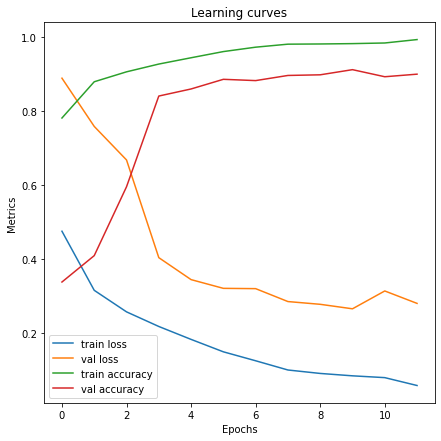

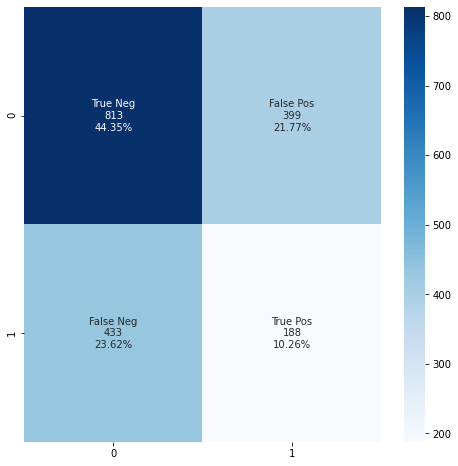

In [11]:
model = get_model()
hist = model.fit(x=X_train, validation_data=X_val, steps_per_epoch=train_step_per_epoch, class_weight=train_class_weights, validation_steps=validation_step_per_epoch, epochs=epochs, callbacks=callback("CNet"), verbose=1).history
cfmat = show_result(hist, X_test, model)

Epoch 1/50
98/98 [==============================] - 83s 842ms/step - loss: 0.4570 - accuracy: 0.7884 - val_loss: 0.9611 - val_accuracy: 0.3681
Epoch 2/50
98/98 [==============================] - 79s 806ms/step - loss: 0.3733 - accuracy: 0.8431 - val_loss: 0.6768 - val_accuracy: 0.6111
Epoch 3/50
98/98 [==============================] - 80s 817ms/step - loss: 0.3510 - accuracy: 0.8496 - val_loss: 0.5434 - val_accuracy: 0.7569
Epoch 4/50
98/98 [==============================] - 78s 792ms/step - loss: 0.3382 - accuracy: 0.8586 - val_loss: 0.5505 - val_accuracy: 0.7257
Epoch 5/50
98/98 [==============================] - 82s 838ms/step - loss: 0.3108 - accuracy: 0.8685 - val_loss: 0.5085 - val_accuracy: 0.7569


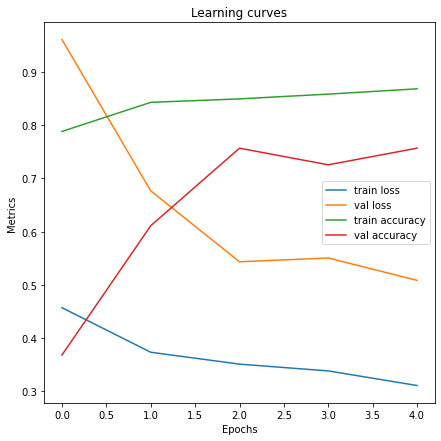

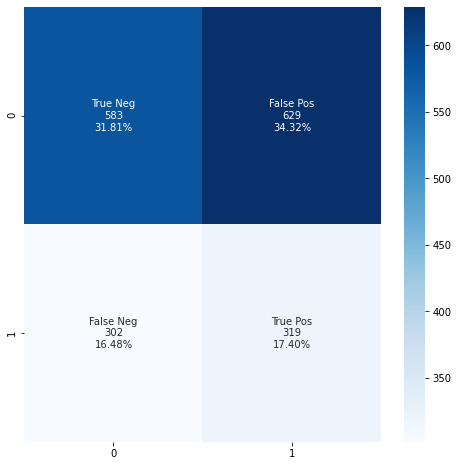

In [12]:
model = get_model()
hist = model.fit(x=X_train_augmented, validation_data=X_val, steps_per_epoch=train_step_per_epoch, class_weight=train_class_weights, validation_steps=validation_step_per_epoch, epochs=epochs, callbacks=callback("CNet_Augmented"), verbose=1).history
cfmat = show_result(hist, X_test, model)

## III - Another approach with transfer learning for feature extraction

In [8]:
# news generators with appropriate params (preprocess function, target_size)
img_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
img_datagen_augmented = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=30, horizontal_flip=True, vertical_flip=True,width_shift_range=0.1, height_shift_range=0.1,zoom_range=.1, shear_range=0.1, fill_mode="nearest")
train_gen = img_datagen_augmented.flow_from_directory(train_path, target_size=(224,224), batch_size=batch_size, shuffle=True)
val_gen = img_datagen.flow_from_directory(val_path, target_size=(224,224), batch_size=batch_size, shuffle=False)
test_gen = img_datagen.flow_from_directory(test_path, target_size=(224,224), batch_size=batch_size, shuffle=False)

Found 3663 images belonging to 2 classes.
Found 610 images belonging to 2 classes.
Found 1833 images belonging to 2 classes.


In [9]:
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

flatten_layer = Flatten()
dense_layer_1 = Dense(64, activation='relu')

dense_layer_2 = Dense(32, activation='relu')
prediction_layer = Dense(2, activation='softmax')
dropout_layer = lambda x: Dropout(x)

model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer(.2),
    dense_layer_2,
    dropout_layer(.25),
    prediction_layer
])

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

Epoch 1/50
98/98 [==============================] - 75s 736ms/step - loss: 0.2544 - accuracy: 0.9115 - val_loss: 0.1189 - val_accuracy: 0.9583


C:\Users\m4tt\anaconda3\envs\ML\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
98/98 [==============================] - 72s 735ms/step - loss: 0.1508 - accuracy: 0.9519 - val_loss: 0.0760 - val_accuracy: 0.9792
Epoch 3/50
98/98 [==============================] - 71s 723ms/step - loss: 0.1149 - accuracy: 0.9622 - val_loss: 0.0776 - val_accuracy: 0.9688
Epoch 4/50
98/98 [==============================] - 71s 722ms/step - loss: 0.1050 - accuracy: 0.9667 - val_loss: 0.0820 - val_accuracy: 0.9740


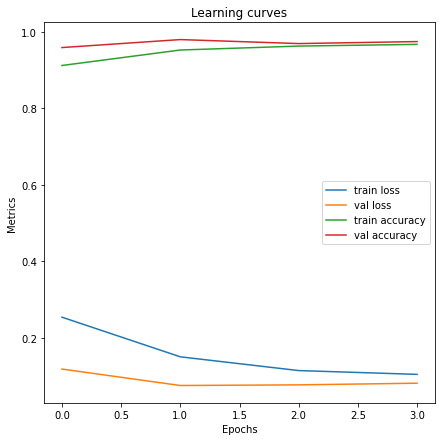

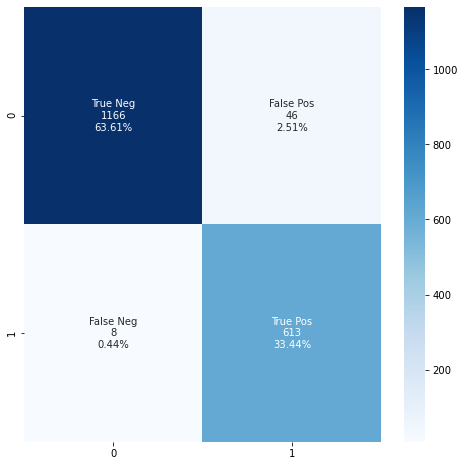

In [10]:
hist = model.fit(x=train_gen, validation_data=val_gen, callbacks=callback("MNet"), epochs=epochs, class_weight=train_class_weights, batch_size=batch_size, steps_per_epoch=train_step_per_epoch, validation_steps=validation_step_per_epoch).history
cf_mat = show_result(hist, test_gen, model)

Epoch 1/50
98/98 [==============================] - 73s 726ms/step - loss: 0.2822 - accuracy: 0.9196 - val_loss: 0.0871 - val_accuracy: 0.9722


C:\Users\m4tt\anaconda3\envs\ML\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
98/98 [==============================] - 70s 713ms/step - loss: 0.1626 - accuracy: 0.9580 - val_loss: 0.0776 - val_accuracy: 0.9792
Epoch 3/50
98/98 [==============================] - 71s 728ms/step - loss: 0.1193 - accuracy: 0.9718 - val_loss: 0.0664 - val_accuracy: 0.9809
Epoch 4/50
98/98 [==============================] - 74s 755ms/step - loss: 0.1153 - accuracy: 0.9707 - val_loss: 0.0663 - val_accuracy: 0.9792
Epoch 5/50
98/98 [==============================] - 71s 720ms/step - loss: 0.1048 - accuracy: 0.9708 - val_loss: 0.0565 - val_accuracy: 0.9809


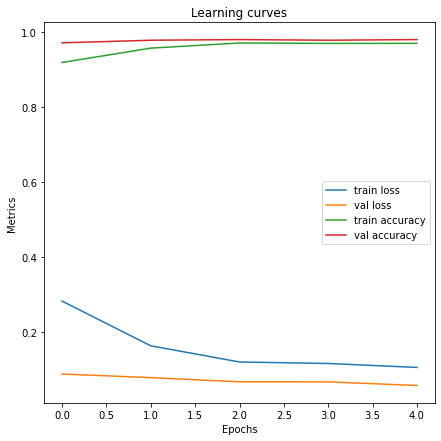

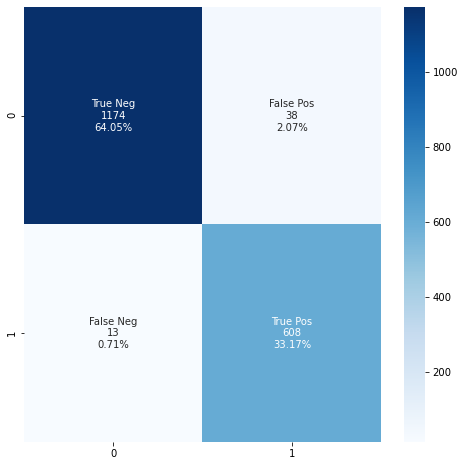

In [15]:
hist = model.fit(x=train_gen, validation_data=val_gen, callbacks=callback("MNet_Augmented"), epochs=epochs, class_weight=train_class_weights, batch_size=batch_size, steps_per_epoch=train_step_per_epoch, validation_steps=validation_step_per_epoch).history
cf_mat = show_result(hist, test_gen, model)

## Finally train the best model on the train-test

In [11]:
MNet = load_model("../asset/data/models/MNet.h5")

In [25]:
a = next(val_gen)[0][0]
a = preprocess_input(a)
np.array(a).shape

(224, 224, 3)

In [28]:
MNet.predict(np.expand_dims(a, axis=0))

array([[9.9999964e-01, 4.1216555e-07]], dtype=float32)

In [29]:
np.argmax(MNet.predict(np.expand_dims(a, axis=0)), axis=1)[0]

0